In [8]:
import math, os, sys
import json
import plotly.express as px
import pandas as pd
import numpy as np
import cv2
from skimage import io
from matplotlib import pyplot as plt
from collections import defaultdict
import random, string
from scipy.interpolate import UnivariateSpline, SmoothBivariateSpline,splprep, splev
from datetime import datetime
HOME = os.path.expanduser("~")
PATH = os.path.join(HOME, 'programming/activebrainatlas')
sys.path.append(PATH)
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "activebrainatlas.settings")
import django
django.setup()

In [ ]:
def random_string():
    return ''.join(random.choices(string.ascii_lowercase + string.digits, k=40))

In [ ]:
from plotly.offline import plot
import plotly.graph_objects as go

In [2]:
from neuroglancer.models import UrlModel, LayerData, Structure, Transformation
from brain.models import Animal, ScanRun
from neuroglancer.atlas import brain_to_atlas_transform, align_atlas

In [ ]:
com_users = LayerData.objects.filter(active=True).values('person_id').distinct()
com_dates = LayerData.objects.filter(active=True)\
.filter(input_type__input_type__in=['manual', 'detected'])\
.values_list('created', flat=True).distinct().order_by()
print(com_dates)

In [ ]:
users = User.objects.filter(id__in=com_users)

In [ ]:
Animal.objects.filter(layerdata__active=True).distinct().order_by()

In [ ]:
count = LayerData.objects.filter(prep_id='Atlas').filter(active=True).count()        
print(count, type(count))

In [ ]:
id = 283 # has points
#id = 307 # not points
urlModel = UrlModel.objects.get(pk=id)
urlModels = [urlModel]

In [ ]:
urlModels = UrlModel.objects.filter(vetted=True).all()
print(len(urlModels))

In [ ]:
dfs = []
for urlModel in urlModels:
    json_txt = urlModel.url
    layers = json_txt['layers']
    for layer in layers:
        if 'annotations' in layer:
            name = layer['name']
            annotation = layer['annotations']
            d = [row['point'] for row in annotation if 'point' in row and 'pointA' not in row]
            df = pd.DataFrame(d, columns=['X', 'Y', 'Section'])
            df['Section'] = df['Section'].astype(int)
            df['Layer'] = name
            structures = [row['description'] for row in annotation if 'description' in row]
            if len(structures) != len(df):
                structures = ['' for row in annotation if 'point' in row and 'pointA' not in row]
            df['Description'] = structures
            df = df[['Layer', 'Description', 'X', 'Y', 'Section']]
            dfs.append(df)
    if len(dfs) == 0:
        result = None
    elif len(dfs) == 1:
        result = dfs[0]
    else:
        result = pd.concat(dfs)

In [ ]:
result.head()

In [ ]:
json_txt = urlModel.url
layer_list = []
layers = json_txt['layers']
for layer in layers:
    if 'annotations' in layer:
        layer_name = layer['name']
        layer_list.append(layer_name)
print(layer_list)
print(urlModel.layers)

In [ ]:
from django.db.models import Count
result = Task.objects.all().filter(lookup__channel__in=[0,1]).filter(lookup__downsample=False)\
.filter(prep__active=True)\
.values('prep_id').annotate(total=Count('prep_id')).order_by('prep_id')

In [ ]:
animals = Animal.objects.filter(active=True).order_by('prep_id').all()
tasks = TaskView.objects.filter(prep_id__in=animals).order_by('prep_id').all()
lookups = ProgressLookup.objects.filter(channel__in=[0,1]).filter(downsample=False).order_by('id').all()

al = []
x = [] 
i = 0
for animal in animals:
    if animal.aliases_1 is None:
        continue
    al.append(str(animal.prep_id + '-' + animal.aliases_1))
    x.append(result[i]['total'])
    i += 1

lookup_list = []
id_list = []
for i, lookup in enumerate(lookups):
    id_list.append(i)
    lookup_list.append(lookup.description)

In [ ]:
get_colors = lambda n: list(map(lambda i: "#" + "%06x" % random.randint(0x00FF00, 0x00FFFF), range(n)))
colors = get_colors(len(x))
#colors = [x*19 for x in range(len(x))]
marker={'color': colors, 'colorscale': 'Viridis'}
fig = go.Figure(data=[go.Bar(x=x, y=al, orientation='h', marker=marker )])
fig.update_layout(xaxis_showgrid=True, yaxis_showgrid=True, height=600)
fig.update_xaxes(ticks='outside',tickwidth=2, tickangle=45, tickcolor='crimson', ticklen=10, range=[0,limit-1])
fig.update_layout(autosize=True, xaxis=dict(tickmode='array', tickvals=id_list, ticktext=lookup_list),
                  margin=dict(l=20, r=20, t=20, b=280),
                  paper_bgcolor="LightSteelBlue",
                  )
fig.show()

In [ ]:
df = pd.DataFrame(list(LayerData.objects.all().values()))
df2 = df.groupby([df['created'].dt.date])[["x", "y", "section"]].mean()
df2.head(2)

In [3]:
INPUT = '/net/birdstore/Active_Atlas_Data/data_root/pipeline_data/DK52/preps/CH3/thumbnail_aligned'
section = 201
file = f'{section}.tif' 
infile = os.path.join(INPUT, file)
prep_id = 'DK52'
layer_name = 'PremotorShape'
input_type_id = 5
rows = LayerData.objects.filter(prep_id=prep_id).filter(layer=layer_name)\
    .filter(input_type_id=input_type_id).filter(active=True).order_by('section','id').all()
print(len(rows))

824


In [4]:
data_dict = defaultdict(list)
for row in rows:
    id = row.segment_id
    x = int(row.x // 32)
    y = int(row.y // 32)
    section = row.section
    data_dict[(id,section)].append((x,y))

In [5]:
for (id,section), points in data_dict.items():
    if section == 201:
        print(id,section, len(points))

64689 201 18
64690 201 6
64807 201 4
64808 201 4
64809 201 5
64810 201 3
64811 201 4


In [ ]:
data = []
for (id,section), points in data_dict.items():
    lp = len(points)
    for i in  range(lp):
        tmp_dict = {}
        pointA = points[i]
        try:
            pointB = points[i+1]
        except IndexError as error:
            pointB = points[0]
        tmp_dict['id'] = random_string()
        tmp_dict['pointA'] = [pointA[0], pointA[1], section]
        tmp_dict['pointB'] = [pointB[0], pointB[1], section]
        tmp_dict['type'] = 'line'
        tmp_dict['description'] = ""
        data.append(tmp_dict)

In [7]:
id = 64689
section = 201
points = data_dict[(id,section)]
print(len(points), id, section)
#for (k,v), points in data_dict.items():
#    print(k,v, len(points)
print(points)


18 64689 201
[(1408, 577), (1389, 582), (1367, 590), (1367, 591), (1350, 596), (1335, 601), (1328, 615), (1328, 629), (1348, 638), (1350, 639), (1370, 641), (1392, 635), (1402, 632), (1416, 616), (1427, 610), (1439, 598), (1442, 585), (1429, 578)]


In [67]:
def interpolate_list(points, new_len):
    x = [v[0] for v in points]
    y = [v[1] for v in points]
    vx = np.array(x)
    vy = np.array(y)
    indices = np.arange(0,len(points))
    new_indices = np.linspace(0,len(points)-1,new_len)
    splx = UnivariateSpline(indices,vx,k=3,s=0)
    x_array = splx(new_indices)
    sply = UnivariateSpline(indices,vy,k=3,s=1)
    y_array = sply(new_indices)
    arr_2d = np.concatenate([x_array[:,None],y_array[:,None]], axis=1)
    a = list(map(tuple, arr_2d))
    return a

def interpolate(points, new_len):
    pu = points.astype(int)
    indexes = np.unique(pu, axis=0, return_index=True)[1]
    points = np.array([pu[index] for index in sorted(indexes)])
    addme = points[0].reshape(1,2)
    points = np.concatenate((points,addme), axis=0)

    tck, u = splprep(points.T, u=None, s=3, per=1) 
    u_new = np.linspace(u.min(), u.max(), new_len)
    x_array, y_array = splev(u_new, tck, der=0)
    arr_2d = np.concatenate([x_array[:,None],y_array[:,None]], axis=1)
    return arr_2d



In [ ]:
points

In [ ]:
points = sub_dict
new_len = max(len(points),20)
delta = (len(points)-1) / (new_len-1)

#outp = [interpolate(points, i*delta) for i in range(new_len)]
outp = interpolate(points, new_len)

outp = [(int(i), int(j)) for i,j in outp]

print('points',(points))
print('lin out',outp)
print('len original array', len(points))
print('len new array', len(outp))




In [ ]:
# python lists of x,y dst control points and zx=xsrc-xdiff, zy=ysrc-ydiff offsets to be interpolated over full image of size 129x129
#x = [8.5, 20.5, 33.5, 48.5, 64.5, 80.5, 95.5, 109.5, 121.5, 5.5, 17.5, 31.5, 46.5, 64.5, 81.5, 97.5, 111.5, 123.5, 2.5, 14.5, 29.5, 45.5, 64.5, 83.5, 99.5, 113.5, 125.5, 1.5, 12.5, 26.5, 43.5, 64.5, 85.5, 103.5, 116.5, 127.5, 0.5, 11.5, 24.5, 41.5, 64.5, 87.5, 103.5, 117.5, 128.5, 1.5, 12.5, 25.5, 42.5, 64.5, 86.5, 103.5, 116.5, 127.5, 2.5, 14.5, 28.5, 45.5, 64.5, 83.5, 100.5, 114.5, 125.5, 5.5, 17.5, 30.5, 46.5, 64.5, 81.5, 97.5, 111.5, 123.5, 8.5, 19.5, 33.5, 48.5, 64.5, 80.5, 95.5, 109.5, 121.5]
#y = [7.5, 5.5, 3.5, 1.5, 1.5, 1.5, 3.5, 5.5, 7.5, 20.5, 16.5, 14.5, 12.5, 11.5, 12.5, 15.5, 16.5, 19.5, 33.5, 31.5, 28.5, 26.5, 24.5, 26.5, 28.5, 31.5, 33.5, 48.5, 47.5, 45.5, 42.5, 40.5, 42.5, 45.5, 46.5, 48.5, 64.5, 64.5, 64.5, 64.5, 64.5, 64.5, 64.5, 64.5, 64.5, 80.5, 81.5, 83.5, 86.5, 87.5, 86.5, 83.5, 81.5, 80.5, 95.5, 97.5, 100.5, 103.5, 104.5, 102.5, 100.5, 97.5, 95.5, 109.5, 111.5, 114.5, 116.5, 117.5, 116.5, 114.5, 111.5, 109.5, 121.5, 123.5, 125.5, 127.5, 127.5, 127.5, 125.5, 123.5, 120.5]
#zx = [119.5, 123.5, 126.5, 127.5, 127.5, 127.5, 128.5, 130.5, 134.5, 122.5, 126.5, 128.5, 129.5, 127.5, 126.5, 126.5, 128.5, 132.5, 125.5, 129.5, 130.5, 130.5, 127.5, 124.5, 124.5, 126.5, 130.5, 126.5, 131.5, 133.5, 132.5, 127.5, 122.5, 120.5, 123.5, 128.5, 127.5, 132.5, 135.5, 134.5, 127.5, 120.5, 120.5, 122.5, 127.5, 126.5, 131.5, 134.5, 133.5, 127.5, 121.5, 120.5, 123.5, 128.5, 125.5, 129.5, 131.5, 130.5, 127.5, 124.5, 123.5, 125.5, 130.5, 122.5, 126.5, 129.5, 129.5, 127.5, 126.5, 126.5, 128.5, 132.5, 119.5, 124.5, 126.5, 127.5, 127.5, 127.5, 128.5, 130.5, 134.5]
#zy = [120.5, 122.5, 124.5, 126.5, 126.5, 126.5, 124.5, 122.5, 120.5, 123.5, 127.5, 129.5, 131.5, 132.5, 131.5, 128.5, 127.5, 124.5, 126.5, 128.5, 131.5, 133.5, 135.5, 133.5, 131.5, 128.5, 126.5, 127.5, 128.5, 130.5, 133.5, 135.5, 133.5, 130.5, 129.5, 127.5, 127.5, 127.5, 127.5, 127.5, 127.5, 127.5, 127.5, 127.5, 127.5, 127.5, 126.5, 124.5, 121.5, 120.5, 121.5, 124.5, 126.5, 127.5, 128.5, 126.5, 123.5, 120.5, 119.5, 121.5, 123.5, 126.5, 128.5, 130.5, 128.5, 125.5, 123.5, 122.5, 123.5, 125.5, 128.5, 130.5, 134.5, 132.5, 130.5, 128.5, 128.5, 128.5, 130.5, 132.5, 135.5]

x = [v[0] for v in points]
y = [v[1] for v in points]
zx = [200 for x in points]
# convert python lists to numpy arrays
ax = np.asarray(x)
ay = np.asarray(y)
azx = np.asarray(zx)
azy = np.asarray(zy)
# define bbox of interpolated data
minx = min(x)
maxx = max(x)
miny = min(y)
maxy = max(y)
bbox=[minx, maxx, miny, maxy]
# convert bbox to numpy array
abbox = np.asarray(bbox)
# do interpolations
xd = SmoothBivariateSpline(ax, ay, azx, w=None, bbox=abbox, kx=1, ky=1)
interp_func = SmoothBivariateSpline(ax, ay, azx, s=0.1)

In [75]:
pts = "1402.4326171875,578.2587890625,1402.4322981366458,586.6683229813661,1391.919875776397,576.1559006211173"

In [76]:
pts = np.array([tuple(map(float, x.split())) for x in pts.strip().split(',')])

In [77]:
vertices = pts.reshape(pts.shape[0]//2, 2).astype(np.float64)

In [78]:
addme = vertices[0].reshape(1,2)
vertices = np.concatenate((vertices,addme), axis=0)
vertices

array([[1402.43261719,  578.25878906],
       [1402.43229814,  586.66832298],
       [1391.91987578,  576.15590062],
       [1402.43261719,  578.25878906]])

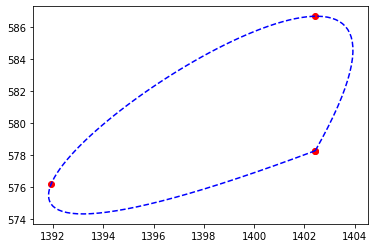

In [88]:
new_len = 100
tck, u = splprep(vertices.T, u=None, s=0.0, per=0) 
u_new = np.linspace(u.min(), u.max(), new_len)
x_array, y_array = splev(u_new, tck, der=0)

plt.plot(vertices[:,0], vertices[:,1], 'ro')
plt.plot(x_array, y_array, 'b--')
plt.show()

In [ ]:
#Set the resolution:
x_res=20
#y_res=int( ( (maxy-miny) / (maxx-minx) )*x_res )
y_res=x_res
#Make a grid
grid_x, grid_y = np.mgrid[minx:maxx:x_res*1j, miny:maxy:y_res*1j]
#xd.ev(grid_x[0,:], grid_y[0,:])

In [ ]:
test_x = np.arange(minx, maxx, 0.5)
test_y = np.arange(miny, maxy, 0.5)
grid_x, grid_y = np.meshgrid(test_x, test_y)

In [ ]:
interp_func(test_x, test_y)

In [ ]:
xd(test_x, test_y)

In [ ]:
file = f'{section}.tif' 
infile = os.path.join(INPUT, file)

img = io.imread(infile, img_num=0)
color = (255,255,255)
for (id,s), points in data_dict.items():
        if s == section and len(points) > 3:
            new_len = max(len(points),5000)
            print(new_len)
            outp = interpolate(points, new_len)
            points = [(int(i), int(j)) for i,j in outp]

            lp = len(points)
            for i in  range(new_len):
                pointA = points[i]
                try:
                    pointB = points[i+1]
                except IndexError as error:
                    pointB = points[0]
                cv2.line(img, pointA, pointB, color, 2)

In [ ]:
#cv2.polylines(img, [points], isClosed=True, color=(0,0,0), thickness=5)
fig=plt.figure(figsize=(26,18), dpi= 100, facecolor='w', edgecolor='k')
plt.imshow(img, cmap="gray")
plt.title('{} section:{}'.format(prep_id, section))
plt.show()

In [71]:
ids = {'infrahypoglossal': 200, 'perifacial': 210, 'suprahypoglossal': 220}

In [72]:
[str(number) for number, label in ids.items()]

['infrahypoglossal', 'perifacial', 'suprahypoglossal']

In [73]:
[str(label) for number, label in ids.items()]

['200', '210', '220']

In [86]:
INPUT = '/net/birdstore/Active_Atlas_Data/data_root/pipeline_data/DK52/preps/CH3/thumbnail_aligned'
files = sorted(os.listdir(INPUT))
for i,file in enumerate(files):
    print(i,file)

0 000.tif
1 001.tif
2 002.tif
3 003.tif
4 004.tif
5 005.tif
6 006.tif
7 007.tif
8 008.tif
9 009.tif
10 010.tif
11 011.tif
12 012.tif
13 013.tif
14 014.tif
15 015.tif
16 016.tif
17 017.tif
18 018.tif
19 019.tif
20 020.tif
21 021.tif
22 022.tif
23 023.tif
24 024.tif
25 025.tif
26 026.tif
27 027.tif
28 028.tif
29 029.tif
30 030.tif
31 031.tif
32 032.tif
33 033.tif
34 034.tif
35 035.tif
36 036.tif
37 037.tif
38 038.tif
39 039.tif
40 040.tif
41 041.tif
42 042.tif
43 043.tif
44 044.tif
45 045.tif
46 046.tif
47 047.tif
48 048.tif
49 049.tif
50 050.tif
51 051.tif
52 052.tif
53 053.tif
54 054.tif
55 055.tif
56 056.tif
57 057.tif
58 058.tif
59 059.tif
60 060.tif
61 061.tif
62 062.tif
63 063.tif
64 064.tif
65 065.tif
66 066.tif
67 067.tif
68 068.tif
69 069.tif
70 070.tif
71 071.tif
72 072.tif
73 073.tif
74 074.tif
75 075.tif
76 076.tif
77 077.tif
78 078.tif
79 079.tif
80 080.tif
81 081.tif
82 082.tif
83 083.tif
84 084.tif
85 085.tif
86 086.tif
87 087.tif
88 088.tif
89 089.tif
90 090.tif
91 091.ti